In [1]:
import numpy as np
import json
import pandas as pd
import copy
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import time
import scipy.stats as stats
import seaborn as sns
from collections import Counter
from ipywidgets import widgets
from IPython.display import display, clear_output

In [2]:
text = widgets.Text()

In [3]:
def handle_sender(sender):
    print(text.value)

In [4]:
text.value

''

In [5]:
class T3Player():
    def __init__(self,dictname = "bayes100k_b.json"):
        self.move_dict = self.read_dict(dictname)
    def write_dict(self,filename,mdict):
        """
        Stores the move dictionary as a json
        INPUTS
        filename(string)
        mdict(dictionary)
        OUTPUTS
        errorflag (0) if failed
        """
        try:
            output_dict = {}
            for k,v in mdict.items():
                cell_dict = {}
                for c,cell in enumerate(v):
                    if type(cell)==int:
                        cell_dict[c]={'alpha':0,'beta':0}
                    else:
                        cell_dict[c]={'alpha':int(cell[0]),'beta':int(cell[1])}
                output_dict[k] = cell_dict
            with open(filename, 'w') as outfile:
                json.dump(output_dict, outfile)
            return 1
        except:
            return 0
    def read_dict(self,filename):
        """
        Reads the move dictionary json file
        INPUTS
        filename(string)
        OUTPUTS
        mdict (dict)
        """
        mdict = {}
        with open(filename) as json_file:
            data = json.load(json_file)
            for k,v in data.items():
                mdict[k] = np.array([[v[str(i)]['alpha'],v[str(i)]['beta']] if v[str(i)]['alpha']>0 else 0 for i in range(9)])
        return mdict
    def findi(self,s, ch):
        """
        finds all indicies of chr in string s
        """
        return [i for i, ltr in enumerate(s) if ltr == ch]
    def is_entry(self,cb):
        """
        Load entry from move dictionary or else creates one
        inputs:
        cb = current_board (string ex. 'EEEEEEEEE')
        outputs:
        prob,md - updated move_dictionary
        """
        # is there an entry?
        if cb in self.move_dict: 
            #get the stored probability coefficients
            prob = self.move_dict[cb]
        else: 
            #create a new entry
            prob = np.array([[1,1] if cb[i]=='E' else 0 for i in range(9) ])
            self.move_dict[cb] = prob
        return prob
    def is_winner(self,player):
        """
        Checks if player has won
        INPUT:
        player - the set of indecies the player currently has a piece on.
        """
        if player is not None:
            win_set = [{0,1,2},{3,4,5},{6,7,8},{0,4,8},{0,3,6},{1,4,7},{2,4,6},{2,5,8}]
            for a in win_set:
                if player.issuperset(a):
                    return a
            else:
                return False
        return False
    def make_move(self,prob_dist,cb):
        """
        Makes a move based on the probability distribution
        """
        #find all empty indexes
        ind = self.findi(cb,'E')
        #determine who's playing then check to see if there are any winning moves
        #playing the winning move is possible, or blocking the opponent's winning move is necessary
        nu_O = cb.count('O')
        nu_X = cb.count('X')
        
        if nu_X>nu_O: #it's O's turn
            #check if cell will win game
            for cell in ind:
                moves = set(self.findi(cb,'O'))
                moves.add(cell)
                if self.is_winner(moves) is not False:
                    return cell
            #else check if cell will prevent loss of game
            for cell in ind:
                moves = set(self.findi(cb,'X'))
                moves.add(cell)
                if self.is_winner(moves) is not False:
                    return cell  
        else: #it's X's turn
            #check if cell will win game
            for cell in ind:
                moves = set(self.findi(cb,'X'))
                moves.add(cell)
                if self.is_winner(moves) is not False:
                    return cell
            #else check if cell will prevent loss of game
            for cell in ind:
                moves = set(self.findi(cb,'O'))
                moves.add(cell)
                if self.is_winner(moves) is not False:
                    return cell        

        ps = np.zeros(9)
        #choose a move by sampling the probability distributions and randomly pick the best one.
        for i in ind:
            ps[i] = stats.beta.rvs(prob_dist[i][0],prob_dist[i][0],0,1,1)[0]
        return ps.argmax()
    
    def play_token(self,current_board,i):
        """
        Update gameboard based on current play
        """
        nu_O = current_board.count('O')
        nu_X = current_board.count('X')
        #update gameboard
        if nu_X>nu_O: #it's O's turn:
            return (current_board[:i] + 'O' + current_board[(i+1):])
        else:    
            return (current_board[:i] + 'X' + current_board[(i+1):])
    
    def move(self,board):
        """
            Make a move
        """
        #check if there's an entry and get probability distribution for that board
        prob = self.is_entry(board)
        #make a move
        move_i = self.make_move(prob,board)
        #then play token, updating the board accordingly
        board = self.play_token(board,move_i)
        return board

    def update_dict(self,mdict,pmoves,wt = 1):
        """
        updates the move_dict based on the players moves (that led to a win)
        """
        for board,cell in pmoves.items():
            #get current prob
            p = mdict[board]
            #improve cell
            if wt == 1: #if a positive result
                p[cell][0] = p[cell][0] + 1
            else:
                p[cell][1] = p[cell][1] + 1
            mdict[board] = p
        return mdict

    def show_game(self,board,fig,ax):
        """
        Plots the board, returns boolean when game ends
        """
        over = False

        #set up the plot space
        ax.set_xlim(0.5,3.5)
        ax.set_ylim(0.5,3.5)
        ax.axhline(1.5,color='grey')
        ax.axhline(2.5,color='grey')
        ax.axvline(1.5,color='grey')
        ax.axvline(2.5,color='grey')
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)

        play_x = set(self.findi(board,'X'))
        play_o = set(self.findi(board,'O'))
        cel_coord = {0:(1,3),1:(2,3),2:(3,3),3:(1,2),4:(2,2),5:(3,2),6:(1,1),7:(2,1),8:(3,1)}
        for i in play_x:
            ax.plot(cel_coord[i][0],cel_coord[i][1],'kX',markersize=52)

            #check if winner yet
            if self.is_winner(play_x):
                winning_set = self.is_winner(play_x)
                pnt1 = -1
                pnt2 = -1
                for pnt in winning_set:
                    if (pnt1==-1)&(pnt2==-1):
                        pnt1 = pnt
                    else:
                        pnt2 = copy.deepcopy(pnt1)
                        pnt1 = pnt
                        ax.plot([cel_coord[pnt1][0],cel_coord[pnt2][0]],[cel_coord[pnt1][1],cel_coord[pnt2][1]],'g-',\
                                linewidth=4)
                over = True
        for i in play_o:
            ax.plot(cel_coord[i][0],cel_coord[i][1],'ro',markeredgewidth=20,markerfacecolor='w',markersize=52)

            #check if winner yet
            if self.is_winner(play_o):
                winning_set = self.is_winner(play_o)
                pnt1 = -1
                pnt2 = -1
                for pnt in winning_set:
                    if (pnt1==-1)&(pnt2==-1):
                        pnt1 = pnt
                    else:
                        pnt2 = copy.deepcopy(pnt1)
                        pnt1 = pnt
                        ax.plot([cel_coord[pnt1][0],cel_coord[pnt2][0]],[cel_coord[pnt1][1],cel_coord[pnt2][1]],'g-',\
                                linewidth=4)
                over = True
        display(fig)
        clear_output(wait = True)
        return over


In [6]:
a = T3Player()

Text(0.5, 1.0, 'XEOEOOEXO')

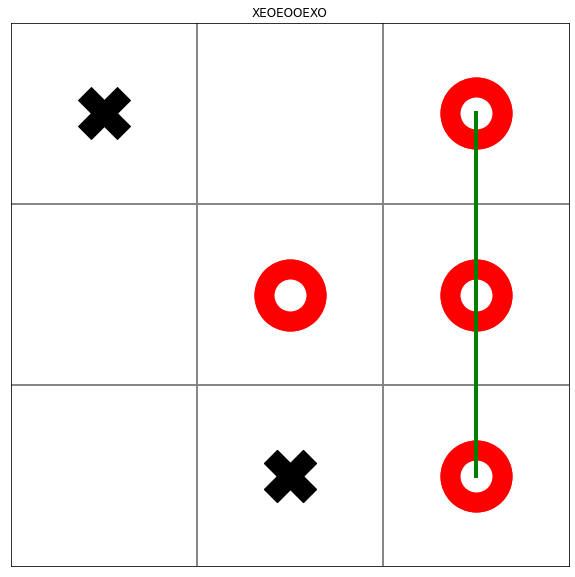

In [7]:
board = "EEOEOOEXO"
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
a.show_game(board,fig,ax)
time.sleep(.5)
board = a.move(board)
a.show_game(board,fig,ax)
plt.title(board)

Please click
clicked [(0.052688172043010795, -0.001804432888988794), (1.7086021505376339, 0.2463212066024172), (3.3349462365591394, 0.315796385660011)]


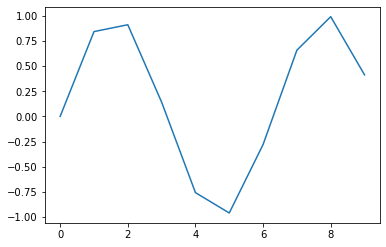

In [8]:
t = np.arange(10)
%matplotlib qt
plt.plot(t, np.sin(t))
print("Please click")
x = plt.ginput(3)
print("clicked", x)
plt.show()